Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                  │ (None, 5, 128)         │        76,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 21)             │         2,709 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_14 (Reshape)            │ (None, 1, 21)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 211,093 (824.58 KB)

 Trainable params: 211,093 (824.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
659/659 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.2648 - val_loss: 0.0964 - learning_rate: 0.0010
Epoch 2/200
659/659 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1745 - val_loss: 0.1129 - learning_rate: 0.0010
Epoch 3/200
659/659 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1580 - val_loss: 0.1080 - learning_rate: 0.0010
Epoch 4/200
659/659 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1489 - val_loss: 0.1079 - learning_rate: 0.0010
Epoch 5/200
659/659 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1421 - val_loss: 0.1109 - learning_rate: 0.0010
Epoch 6/200
659/659 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1363
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
659/659 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1363 - val_loss: 0.1103 - learning_rate: 0.0010
Epoch 7/200
659/659 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1292 - val_loss: 0.1070 - learning_rate: 1.0000e-04
Epoch 8/200
659/659 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1271 - val_loss: 0.1083

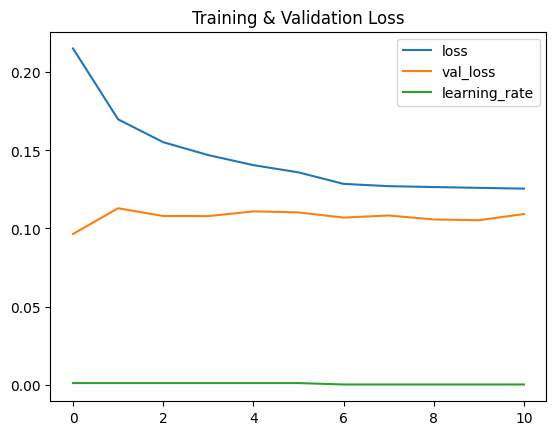

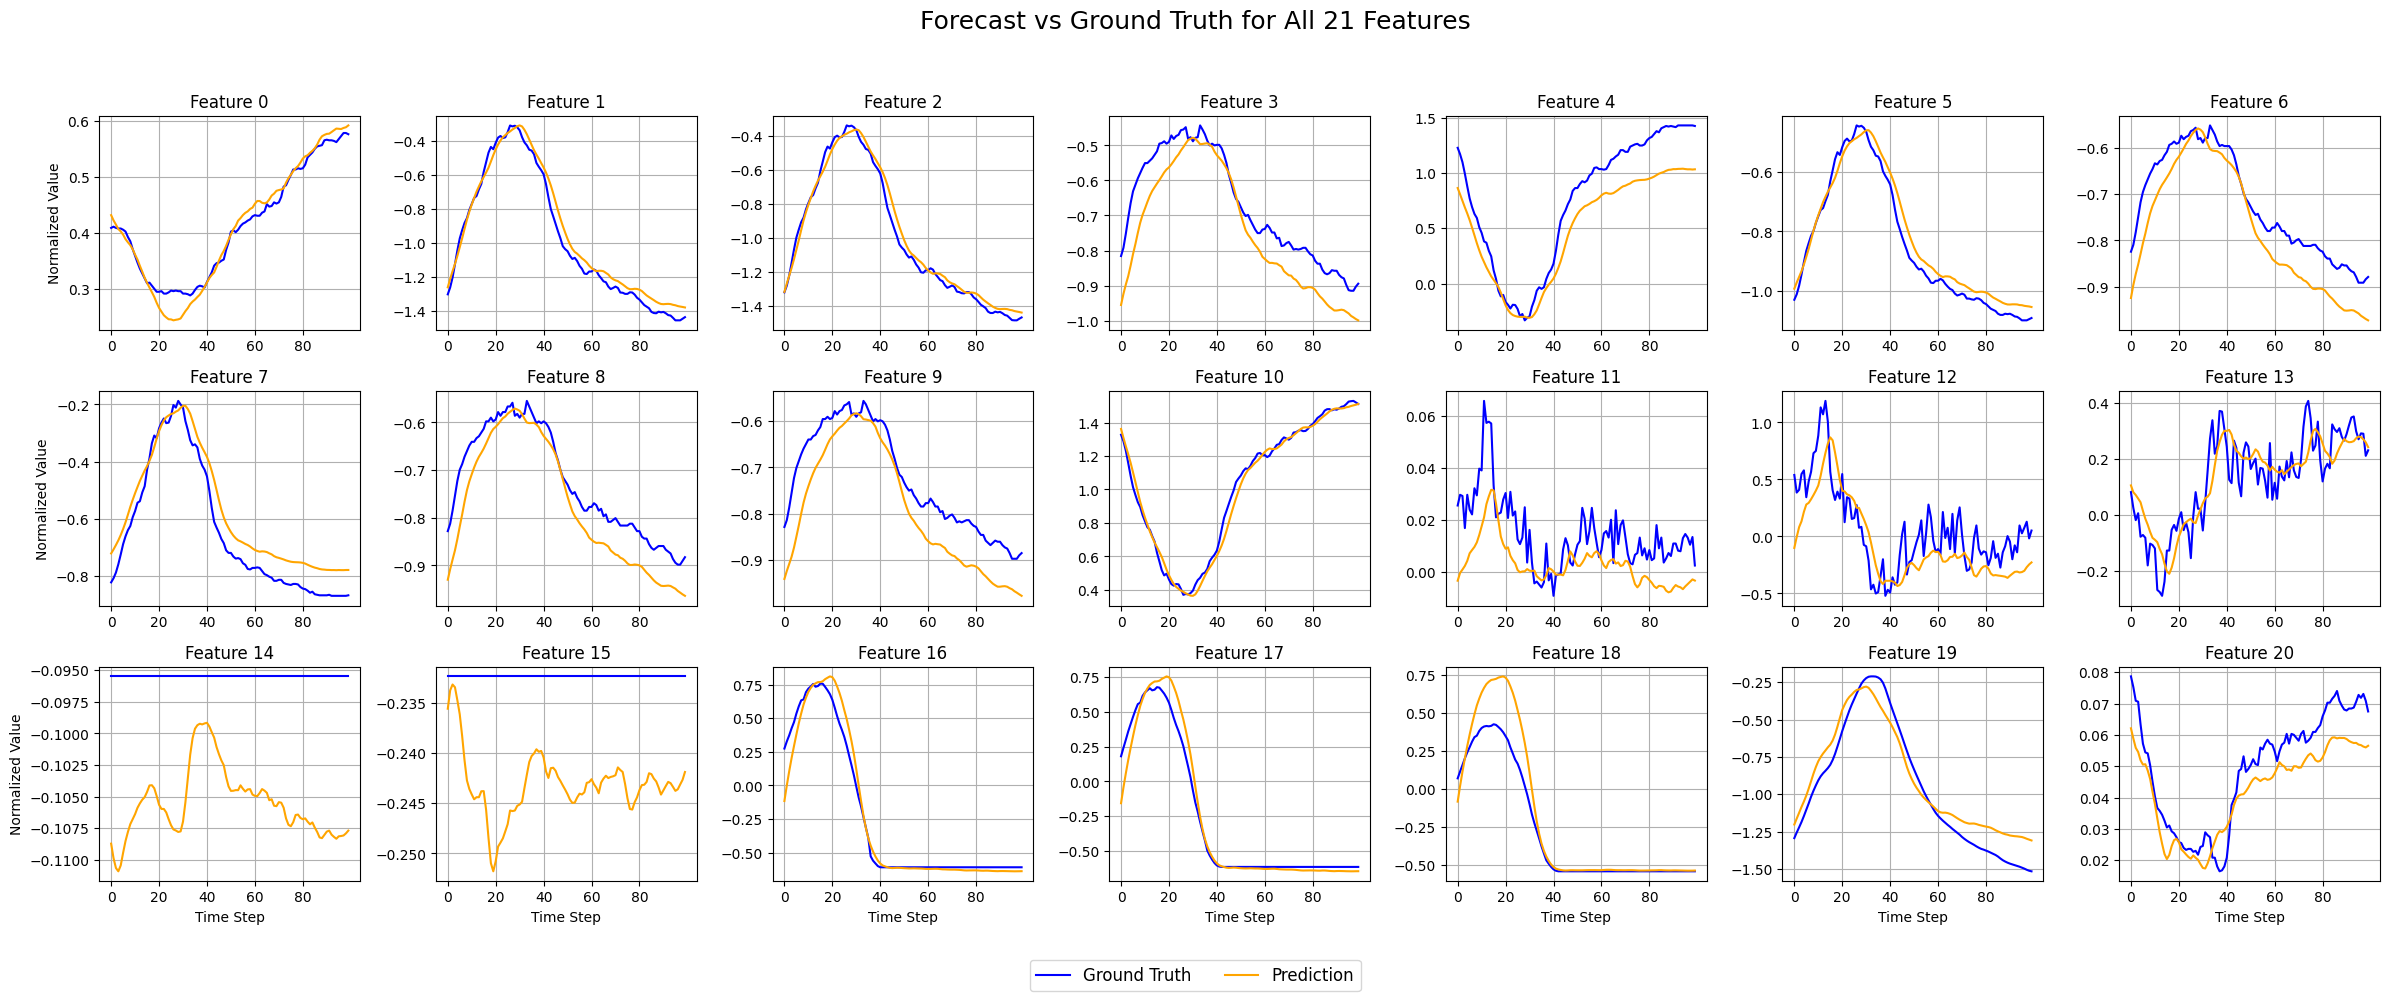

✅ TensorFlow model saved.


In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt

# ---------------------------
# Step 1: Load and Prepare Data
# ---------------------------
df = pd.read_csv('Weather.csv')
df['date'] = pd.to_datetime(df['date'])
data = df.drop(columns=['date'])

# Normalize data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data).astype(np.float32)

# ---------------------------
# Step 2: Create Sequences
# ---------------------------
def create_sequences(data, input_len=5, output_len=1, stride=1):
    X, y = [], []
    for i in range(0, len(data) - input_len - output_len + 1, stride):
        X.append(data[i:i+input_len])
        y.append(data[i+input_len:i+input_len+output_len])
    return np.array(X), np.array(y)

INPUT_LEN = 5
OUTPUT_LEN = 1
X, y = create_sequences(data_scaled, INPUT_LEN, OUTPUT_LEN, stride=1)

# Split into train, val, test
train_size = int(0.8 * len(X))
val_size = int(0.1 * len(X))
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

# ---------------------------
# Step 3: TensorFlow Dataset
# ---------------------------
BATCH_SIZE = 64

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train)).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

# ---------------------------
# Step 4: Model Definition (Updated)
# ---------------------------
input_shape = X_train.shape[1:]  # (input_len, num_features)
output_size = y_train.shape[-1]  # 21 features
hidden_size = 128
num_layers = 2

model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=input_shape))
for i in range(num_layers):
    model.add(tf.keras.layers.LSTM(hidden_size, return_sequences=(i < num_layers - 1), dropout=0.2))
model.add(tf.keras.layers.Dense(OUTPUT_LEN * output_size))
model.add(tf.keras.layers.Reshape((OUTPUT_LEN, output_size)))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mae'
)

model.summary()

# ---------------------------
# Step 5: Training with Early Stopping and LR Scheduler
# ---------------------------
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=200,
    callbacks=[early_stop, lr_schedule]
)

pd.DataFrame(history.history).plot(title="Training & Validation Loss")

# ---------------------------
# Step 6: Evaluate on Test Set
# ---------------------------
test_loss = model.evaluate(test_ds)
print(f"\n🧪 Test Loss: {test_loss:.4f}")

# ---------------------------
# Step 7: Predictions and Plotting
# ---------------------------
preds_arr = model.predict(test_ds)
targets_arr = np.concatenate([y for _, y in test_ds], axis=0)

print(f"Predictions shape: {preds_arr.shape}")
print(f"Targets shape: {targets_arr.shape}")

# Plotting
num_features = output_size
fig, axes = plt.subplots(nrows=3, ncols=7, figsize=(24, 10))
fig.suptitle("Forecast vs Ground Truth for All 21 Features", fontsize=18)

for i in range(num_features):
    row, col = divmod(i, 7)
    ax = axes[row][col]
    ax.plot(targets_arr[:100, 0, i], label="Ground Truth", color="blue")
    ax.plot(preds_arr[:100, 0, i], label="Prediction", color="orange")
    ax.set_title(f"Feature {i}")
    ax.set_xticks(np.arange(0, 100, 20))
    ax.grid(True)
    if row == 2:
        ax.set_xlabel("Time Step")
    if col == 0:
        ax.set_ylabel("Normalized Value")

handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=12, bbox_to_anchor=(0.5, -0.01))
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

# ---------------------------
# Step 8: Save Model
# ---------------------------
model.save("lstm_weather_model_tuned_tf.keras")
print("✅ TensorFlow model saved.")